<a href="https://colab.research.google.com/github/Bryan-Az/Adv-Keras-NNs/blob/main/Part2/Adv_Tabular_Keras_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An AB Test of Augmented Data and Regularizations


# Imports

In [ ]:
# time-series data augmentation for numeric data
!pip install tsaug
import tsaug
import numpy as np
from tsaug.visualization import plot

# model creation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# for the keras tensorflow model
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# Creating Augmented Data using Environmental Data Distributions

# Loading and Processing Numerical Features
This will help when processing with the regression model. This data was previously processed in my 'Keras-HF-FastAi' repository when preparing it to be used with the HuggingFace pre-trained "Tabular Question Answering" M.L model. During an earlier processing step when preparing the data for training with FastAi API model-training data loader methods and Sci-kit Learn's "AdaBoostRegressor" model, it was noticed that the data performed better in regression when the original features like working_capacity, fish_production, crop_production_capacity, etc were split into its tuple components, versus when the tuple components were merged into a single feature. This may be due to each component (feature_1, feature_2, etc.) representing a distinct latent variable. For further information for how the data was processed, refert to my 'Keras-HF-FastAi' repository.

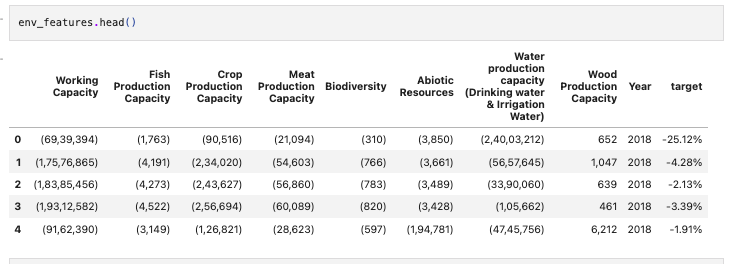

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# importing the file into the environment using google drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname_link_gdrive = {'corp_safeguard_split.csv':'https://drive.google.com/file/d/1mj0mWTZkmrmfD3ItSYrCrf6wGOBkEtau/view?usp=drive_link'}

In [ ]:
csv_name = list(fname_link_gdrive.keys())[0]
id = fname_link_gdrive[csv_name].split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(csv_name)

In [ ]:
environmental_data = pd.read_csv('corp_safeguard_split.csv')

In [ ]:
environmental_data.head()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,...,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,Year,Company Name,target
0,69,39,394.0,445.799955,1,763.0,90,516.0,437.036571,21,...,310,418.64977,3.0,850.0,2,40.0,3.0,2018,APPLUS SERVICES SA,-0.2512
1,1,75,76.0,865.000000,4,191.0,2,34.0,20.000000,54,...,766,418.64977,3.0,661.0,56,57.0,645.0,2018,TELEPERFORMANCE SE,-0.0428
2,1,83,85.0,456.000000,4,273.0,2,43.0,627.000000,56,...,783,418.64977,3.0,489.0,33,90.0,60.0,2018,SGS SA,-0.0213
3,1,93,12.0,582.000000,4,522.0,2,56.0,694.000000,60,...,820,418.64977,3.0,428.0,1,5.0,662.0,2018,INTERTEK GROUP PLC,-0.0339
4,91,62,390.0,445.799955,3,149.0,1,26.0,821.000000,28,...,597,418.64977,1.0,94.0,47,45.0,756.0,2018,THOMSON REUTERS CORP,-0.0191


## Feature Selection for Modelling and Augmentation of the Time Series Feature Distributions
In the Numpy notebook, exploratory data analysis was used to find 2-3 features within the data that would be good choices to non linear regression. In this section, a similar method will be used to apply non-linear regression using Tensorflow low-level functionality that also allows for the creation of a regression model in an object-oriented fashion. For the generation of the synthetic distributions, we need to identify the distribution type and the distribution parameters within the base data, as each variable feature has different distribution characteristics.

### Identifying the distributions & the distribution parameters

In [ ]:
numerical_features = environmental_data.drop(['Company Name'], axis=1)

In this notebook, I will be using the same 3 features (+ the target) identified using the boxplot in the numpy notebook to generate the synthetic distributions. This time, I will be plotting the results in a 4D-plot. I am filtering the data to remove outliers and selecting the 5 most recent years.

In [ ]:
numerical_features.shape

(13177, 20)

In [ ]:
most_recent_year = numerical_features['Year'].max()

# Select rows that are within the 5 most recent years
recent_features = numerical_features[numerical_features['Year'] > most_recent_year - 5]

In [ ]:
year_column = numerical_features['Year']

In [ ]:
recent_features = recent_features.drop('Year', axis=1) # dropping year as it is not a environmental signal

In [ ]:
means = recent_features.mean()
stds = recent_features.std()

# Calculate ymin and ymax for each column
ymins = means - 3 * stds
ymaxs = means + 3 * stds

# Filtering the DataFrame to only include values within ymin and ymax for each column
filtered_numerical_features = recent_features[(recent_features >= ymins) & (recent_features <= ymaxs)].dropna()

In [ ]:
print(numerical_features.shape)
print(filtered_numerical_features.shape)

(13177, 20)
(6557, 19)


In [ ]:
filtered_numerical_features.describe()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,meat_production_capacity_1,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,target
count,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000
mean,20.038585,47.946317,166.746314,443.951521,55.387067,404.281205,19.543389,140.833350,436.210039,21.488181,257.649295,138.462102,420.556388,50.673241,353.629845,20.977429,99.035405,328.361269,-1.143813
std,25.243661,28.918262,249.319003,266.964169,129.647023,298.084564,24.676803,221.374304,271.516195,28.661700,300.369591,226.135342,239.393191,117.611291,295.907676,24.889863,156.221839,293.447537,5.008250
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-97.108400
25%,3.000000,23.000000,32.000000,240.000000,3.000000,103.000000,3.000000,27.000000,214.000000,2.000000,38.000000,2.000000,276.000000,3.000000,73.000000,3.000000,26.000000,65.000000,-0.511900
50%,8.000000,47.000000,65.000000,445.799955,9.000000,400.997112,8.000000,57.000000,437.036571,9.000000,83.000000,14.000000,418.649770,10.000000,357.948948,10.000000,53.000000,322.000000,-0.105000
75%,27.000000,73.000000,97.000000,614.000000,31.000000,649.000000,26.000000,92.000000,617.000000,32.000000,457.000000,197.000000,505.000000,35.000000,576.000000,32.000000,84.000000,534.000000,-0.028000
max,97.000000,185.000000,999.000000,999.000000,706.000000,999.000000,141.000000,957.000000,999.000000,382.000000,999.000000,887.000000,999.000000,694.000000,999.000000,99.000000,808.000000,999.000000,44.022300


## Creating a mask on the timeseries for plotting regions of interest before and after augmentation


In [ ]:
filtered_numerical_features['Year'] = year_column

In [ ]:
filtered_numerical_features.sort_values(by='Year', inplace=True)

In [ ]:
#segmentation mask of it selects areas within the last 7 years
year_recent_mask = filtered_numerical_features['Year'] > 2017.0

In [ ]:
# segmentation mask of biodiversity_0 for use with the tsaug visualization.plot function - it selects areas where the distribution is <300 (to the left of the tail) in numpy
biodiversity_0_mask = filtered_numerical_features['biodiversity_0'] < 300.0

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

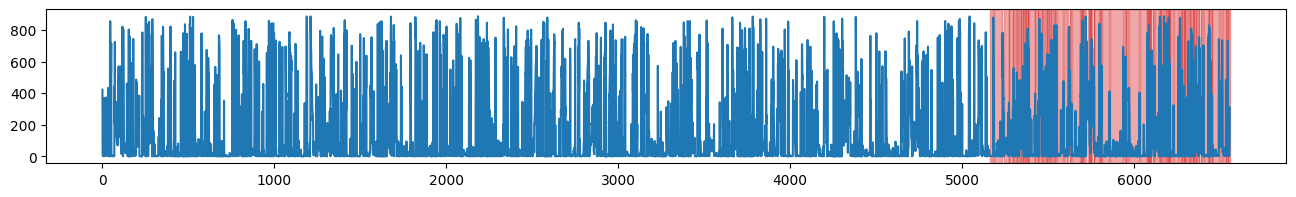

In [ ]:
plot(filtered_numerical_features.loc[:, 'biodiversity_0'].to_numpy(),  biodiversity_0_mask.to_numpy() & year_recent_mask.to_numpy())

In [ ]:
# helps visualize the spike that is seen on the feature distribution in time - - it selects the area to the left of the spike near 400
biodiversity_1_mask_1 = filtered_numerical_features['biodiversity_1'] < 400.0
biodiversity_1_mask = biodiversity_1_mask_1

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

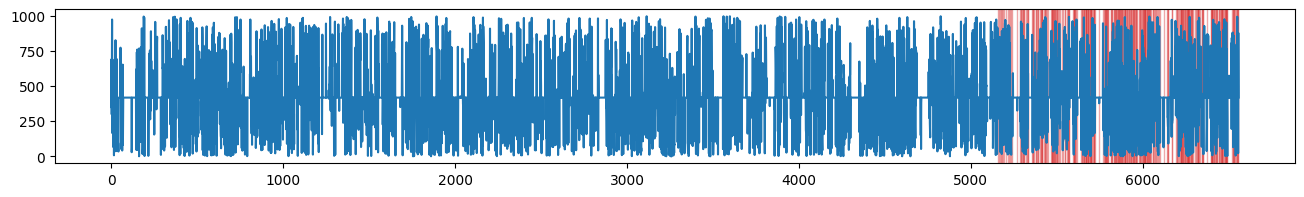

In [ ]:
plot(filtered_numerical_features.loc[:, 'biodiversity_1'].to_numpy(), biodiversity_1_mask.to_numpy() & year_recent_mask.to_numpy())

In [ ]:
#segmentation mask of working_capacity_3 - it selects the area to the left of the spike near 400
working_capacity_3_mask = filtered_numerical_features['working_capacity_3'] < 400.0

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

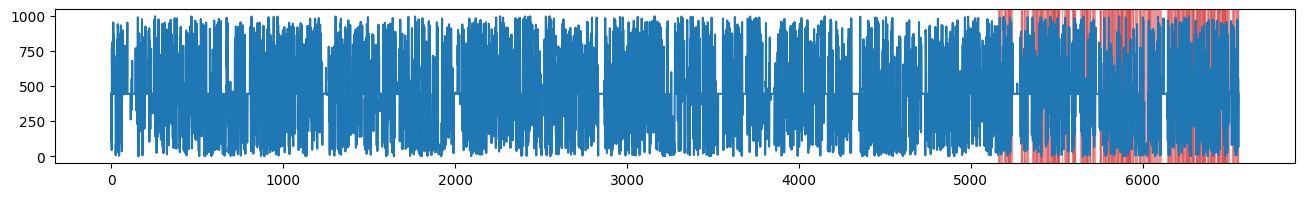

In [ ]:
plot(filtered_numerical_features.loc[:, 'working_capacity_3'].to_numpy(), working_capacity_3_mask.to_numpy() & year_recent_mask.to_numpy())

In [ ]:
#segmentation mask of target - it selects areas in the range -0.511 to 0.64
target_mask = (filtered_numerical_features['target'] > -80) & (filtered_numerical_features['target'] < 40)

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

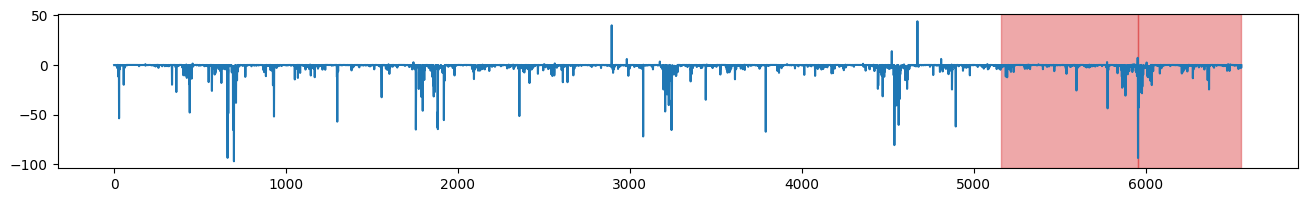

In [ ]:
plot(filtered_numerical_features.loc[:, 'target'].to_numpy(), target_mask.to_numpy() & year_recent_mask.to_numpy())

In [ ]:
X = filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3']].copy(deep=True)

In [ ]:
y = filtered_numerical_features.loc[:, 'target'].copy(deep=True)

In [ ]:
def plot_4d(x, y, z, c, title='4D Plot'):
    """ This function plots the 3 X variables
    as points, and uses color to visualize the target variable.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Assuming x, y, z, and c are numpy arrays or lists of the same length
    # x, y, and z are the coordinates, and c is the color dimension
    ax.scatter(x, y, z, c=c, cmap=plt.hot())

    # Add a colorbar to represent the fourth dimension
    fig.colorbar(ax.scatter(x, y, z, c=c, cmap=plt.hot()),ax=ax, label='Environmental Cost Intensity (%)')

    plt.title(title)
    plt.show()

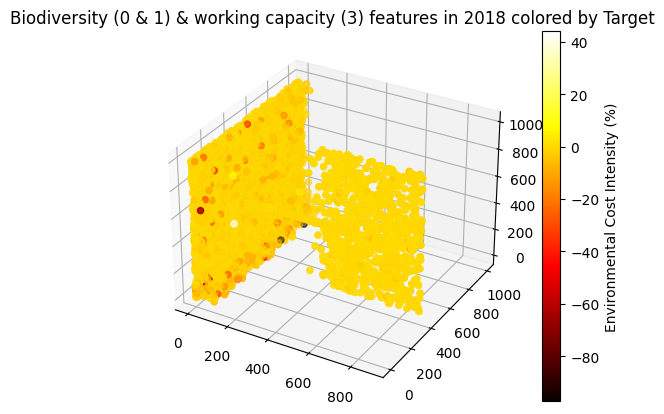

In [ ]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], y, title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')

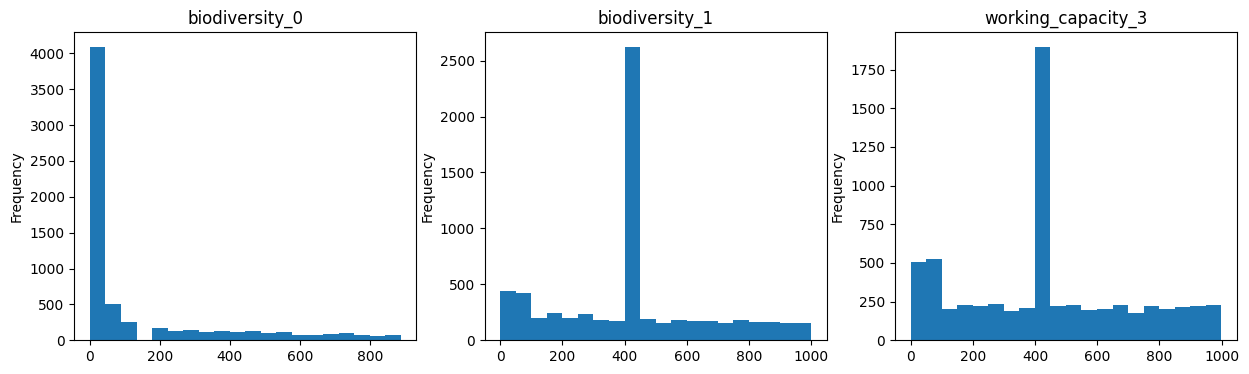

In [ ]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(3 * 5, 4))

# Flatten the array of axes (subplots) for easy iteration
axs_flat = axs.flatten()

for i, column in enumerate(X.columns):
    # Plot the column data in its own subplot
    filtered_numerical_features[column].plot(kind='hist', bins=20, ax=axs_flat[i])
    axs_flat[i].set_title(column)

<Axes: ylabel='Frequency'>

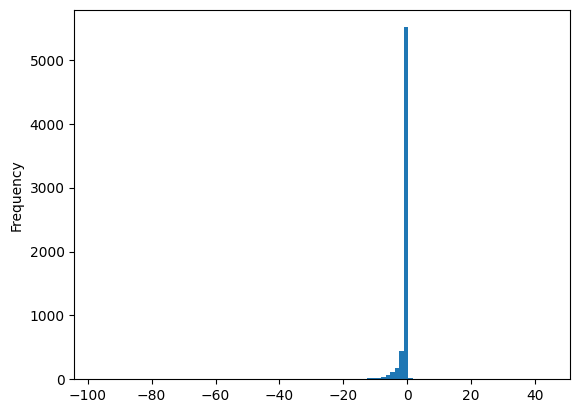

In [ ]:
y.plot(kind='hist', bins=100)

Thoughts on the underlying distributions based on the histograms:
1. The biodiversity_0 feature may be an inverse exponential distribution.
2. The biodiversity_1 feature may be an irregular gaussian as there is a spike near 400.
3. The working_capacity_3 feature may also be an irregular gaussian as there is a spike near 400.
4. The target (environmental cost intensity) feature may be an exponential distribution shifted to the left.

Further hypothesis testing may be done to uncover the underlying distributions generating the data, however, for the purposes of this assignment I will continue by generating the data based on these assumptions.

### Generating the Augmented Data
I'll be applying TSAug to hopefully create a dataset having augmented data based on an estimation of the underlying time series distribution of the three selected variables.

We noticed that the visualization of the features in time looks much different than the visualization of the features without the time variable - this is a tricky distribution and hopefully TSAug can create augmented data that complements this data and is similar in distribution for testing and experimentation with our model.

In [ ]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

In [ ]:
env_data_tsaug = (
    Crop(size=2000) # create a subset augmented set of size n
    + Quantize(n_levels=[10,20,30]) # random quantization level sets
    + Drift(max_drift=(0.01,0.02)) @ 0.8 # randomly drift the data up by 1-2%
    + Reverse() @ 0.5 # randomly reverse the pattern 50% of the time
)

In [ ]:
biodiv0_aug, y_biodiv0_aug = env_data_tsaug.augment(filtered_numerical_features['biodiversity_0'].to_numpy(), biodiversity_0_mask.to_numpy() & year_recent_mask.to_numpy())
biodiv1_aug, y_biodiv1_aug = env_data_tsaug.augment(filtered_numerical_features['biodiversity_1'].to_numpy(), biodiversity_1_mask.to_numpy())
working_aug, y_working_aug = env_data_tsaug.augment(filtered_numerical_features['working_capacity_3'].to_numpy(), working_capacity_3_mask.to_numpy())
target_aug, y_target_aug = env_data_tsaug.augment(filtered_numerical_features['target'].to_numpy(), target_mask.to_numpy())

## Augmenting the X Features

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

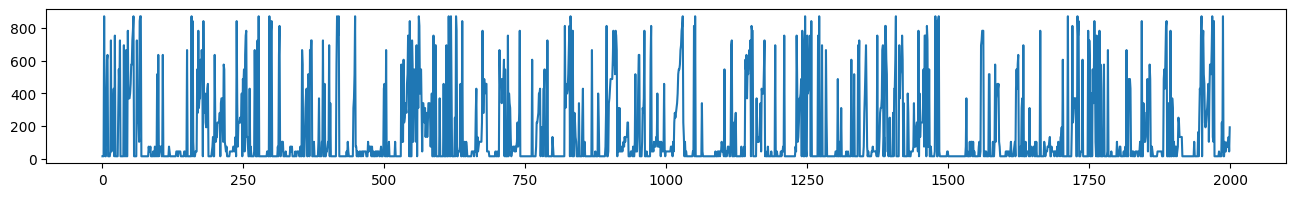

In [ ]:
plot(biodiv0_aug, y_biodiv0_aug) # top plot shows the distribution post augmentation, bottom plot shows the mask to select areas to b

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

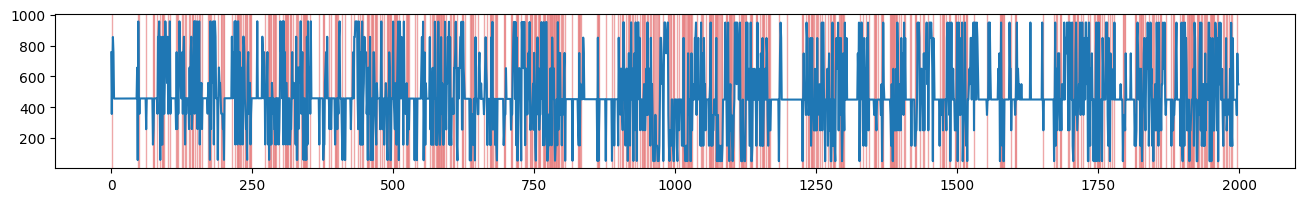

In [ ]:
plot(biodiv1_aug, y_biodiv1_aug)

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

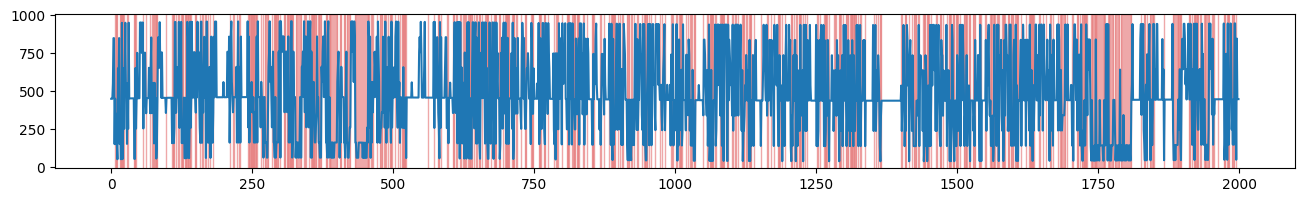

In [ ]:
plot(working_aug, y_working_aug)

## Augmenting the Y Feature

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

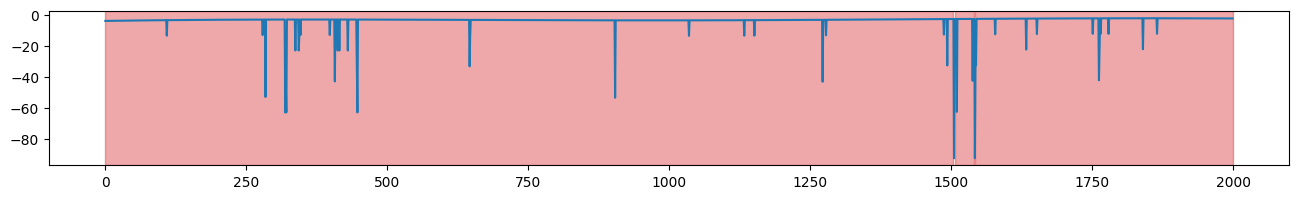

In [ ]:
plot(target_aug, y_target_aug) # as we can see, the target variable is not masked in the areas with the outliers

In [ ]:
# merge biodiv0_aug, biodiv1_aug, and working_aug into a new dataframe with these names for their respective columns
augmented_data = pd.DataFrame({'biodiversity_0': biodiv0_aug, 'biodiversity_1': biodiv1_aug, 'working_capacity_3': working_aug, 'target': target_aug})

The augmented data created with TSAug seems to match some of the key distribution estimators of the original data, such as the standard deviation, mean, and quantiles! This may provide a more fine-grained look at particular sections of the data such as the most recent information and areas of the distribution that are more signal-rich - such as biodiv1 (it has more red due to having a larger mask region).

In [ ]:
filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3', 'target']].describe()

,biodiversity_0,biodiversity_1,working_capacity_3,target
count,6557.000000,6557.000000,6557.000000,6557.000000
mean,138.462102,420.556388,443.951521,-1.143813
std,226.135342,239.393191,266.964169,5.008250
min,1.000000,0.000000,0.000000,-97.108400
25%,2.000000,276.000000,240.000000,-0.511900
50%,14.000000,418.649770,445.799955,-0.105000
75%,197.000000,505.000000,614.000000,-0.028000
max,887.000000,999.000000,999.000000,44.022300


In [ ]:
augmented_data.describe()

,biodiversity_0,biodiversity_1,working_capacity_3,target
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,157.305167,476.804298,479.431314,-3.627079
std,236.452089,231.995115,269.837566,5.106433
min,15.766667,50.259178,37.318776,-92.474126
25%,15.766667,354.711369,255.996515,-3.423947
50%,15.766667,451.939146,446.400745,-3.125566
75%,222.500000,556.818811,658.176584,-2.723441
max,872.233333,957.737467,960.793588,-2.194159


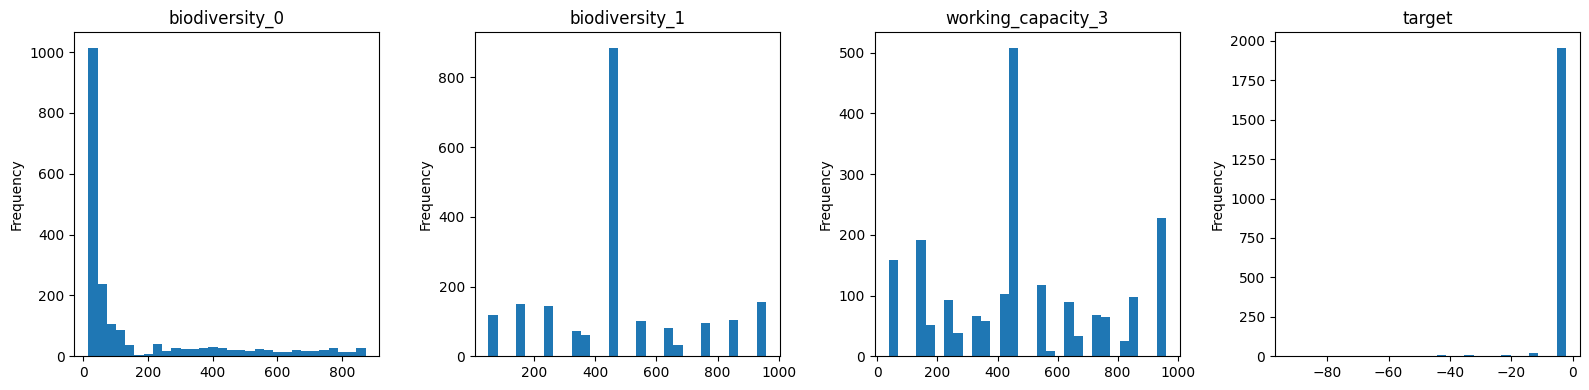

In [ ]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 4))

# Flatten the array of axes (subplots) for easy iteration
axs_flat = axs.flatten()

for i, column in enumerate(augmented_data.columns):
    # Plot the column data in its own subplot
    augmented_data[column].plot(kind='hist', bins=30, ax=axs_flat[i])
    axs_flat[i].set_title(column)
plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

## Scaling the Augmented Numerical Data

In [ ]:
standard_scaler = StandardScaler()
X_scaled=standard_scaler.fit_transform(augmented_data.iloc[:, :-1])

In [ ]:
y_scaled = standard_scaler.fit_transform(augmented_data.iloc[:,-1].to_numpy().reshape(-1, 1))

In [ ]:
print(X_scaled.shape)
print(y_scaled.shape)

(2000, 3)
(2000, 1)


In [ ]:
X_scaled.dtype

dtype('float64')

## Data Transformation

In [ ]:
# using sklearn to split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y_scaled,
                                                    test_size=0.2,
                                                    random_state=88)

In [ ]:
# creating the test/train split
tf_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(8)
tf_test_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(8)

## Custom Einsum Layer

In [ ]:
class EinsumLayer(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(EinsumLayer, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        # Create a trainable weight variable for this layer,
        # which will serve as the second tensor in the einsum operation.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, inputs):
        # Perform the einsum operation combining input tensor and the kernel
        # Here 'ij,jk->ik' essentially performs matrix multiplication
        return tf.einsum('ij,jk->ik', inputs, self.kernel)

## Custom l1 activation function

In [ ]:
def custom_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

## Custom Huber loss function

In [ ]:
def custom_huber_loss(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

## Tuning with KerasTuner

## The Model
It implements the Huber loss, Adam momentum optimizer, custom l1 activation, hyperparameter tuning

In [ ]:
! pip install -q -U keras-tuner
from kerastuner import HyperModel
from kerastuner.tuners import Hyperband


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


<ipython-input-130-4acbbb062200>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [ ]:
def build_model(hp):
    # Instantiate a simple classification model
    # with l1

    model = tf.keras.Sequential([
      tf.keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        activation='relu', input_shape=(3,)),
      EinsumLayer(output_dim=256),
      layers.Dense(256, activation=tf.nn.relu, activity_regularizer=custom_l1_regularizer),
      layers.Dense(256, activation='sigmoid'),
      layers.Dense(1),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss=custom_huber_loss(),
        metrics=['mean_squared_error'])
    return model


In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_mean_squared_error',  # Objective to minimize
    max_epochs=10,
    directory='/content/',
    project_name='keras_tuner_regression_demo'
)


In [ ]:
#tf train dataset is defined already

# Determine the split point, say 80% training, 20% validation
train_size = int(0.8 * X_train.shape[0])

# redefine the train dataset
tf_train_dataset = tf_train_dataset.take(train_size)

# Create the validation dataset
validation_dataset = tf_train_dataset.skip(train_size)


In [ ]:
tuner.search(tf_train_dataset, epochs=50, validation_data=tf_test_dataset)

Trial 30 Complete [00h 00m 25s]
val_mean_squared_error: 1.12886643409729

Best val_mean_squared_error So Far: 1.128839373588562
Total elapsed time: 00h 05m 20s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

## Training the Model on the Augmented Training Data

The augmented data generated with TSAug seems to perform better than with the samples synthetically generated from eye-balled distribution estimators in within the previous [Tensorflow](https://github.com/Bryan-Az/TF-PyTorch-Jax-NN) notebook.

In [ ]:
def train_with_early_stopping(model, tf_train_dataset, tf_test_dataset, num_epochs=10):
  accuracy = tf.keras.metrics.MeanSquaredError()
  optimizer = tf.keras.optimizers.SGD()
  best_val_metric = float('inf')
  best_epoch = 0
  patience = 3

  for epoch in range(num_epochs):
    for step, (x, y) in enumerate(tf_train_dataset):
      # Open a GradientTape.
      with tf.GradientTape() as tape:
        # Forward pass.
        logits = model(x)
        # Loss value for this batch.
        loss_value = tf.reduce_mean(tf.keras.losses.mse(y, logits))

      # Get gradients of loss wrt the weights.
      gradients = tape.gradient(loss_value, model.trainable_weights)

      # Update the weights of our linear layer.
      optimizer.apply_gradients(zip(gradients, model.trainable_weights))

      # Update the running accuracy/ MSE in this case
      accuracy.update_state(y, logits)
      # Logging.
      if step % 20 == 0:
        print('Step:', step)
        print('Loss from last step: %.3f' % loss_value)
        print('Total running accuracy so far: %.3f' % accuracy.result())
    # Evaluate the model on the validation set (tf_test_dataset is a numpy array dataset)
    test_predictions = model(tf_test_dataset)
    # set the val_metric to calculate accuracy using predictions and x_test

    def compute_validation_loss(labels, predictions):
      return tf.reduce_mean(tf.keras.losses.mse(labels, predictions))

    val_metric = compute_validation_loss(y_test, test_predictions)

    # Check if the validation metric has improved.
    if val_metric < best_val_metric:
      best_val_metric = val_metric
      best_epoch = epoch
    else:
      # If the validation metric has not improved for 'patience' epochs, stop training.
      if epoch - best_epoch >= patience:
        print('Early stopping at epoch %d.' % epoch)
        print('Valid. Loss at epoch %d.' % best_val_metric)
        break

    print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss_value)))

  return best_epoch

In [ ]:
train_with_early_stopping(best_model, tf_train_dataset, X_test)

Step: 0
Loss from last step: 0.034
Total running accuracy so far: 0.034
Step: 20
Loss from last step: 4.184
Total running accuracy so far: 0.680
Step: 40
Loss from last step: 0.144
Total running accuracy so far: 0.966
Step: 60
Loss from last step: 0.004
Total running accuracy so far: 0.793
Step: 80
Loss from last step: 0.506
Total running accuracy so far: 1.621
Step: 100
Loss from last step: 0.012
Total running accuracy so far: 1.413
Step: 120
Loss from last step: 0.007
Total running accuracy so far: 1.745
Step: 140
Loss from last step: 2.006
Total running accuracy so far: 1.621
Step: 160
Loss from last step: 0.007
Total running accuracy so far: 1.652
Step: 180
Loss from last step: 0.010
Total running accuracy so far: 1.475
Epoch 0: last batch loss = 0.0093
Step: 0
Loss from last step: 0.006
Total running accuracy so far: 1.343
Step: 20
Loss from last step: 0.798
Total running accuracy so far: 1.289
Step: 40
Loss from last step: 3.681
Total running accuracy so far: 1.396
Step: 60
Loss 

2

# Evaluating the custom l1, HuberLoss, and momentum optimized model on the Augmented Testing Data

## The Real Data Y 'Truth' Labels

In [ ]:
X = filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3']].copy(deep=True)
y = filtered_numerical_features.loc[:, ['target']].copy(deep=True)

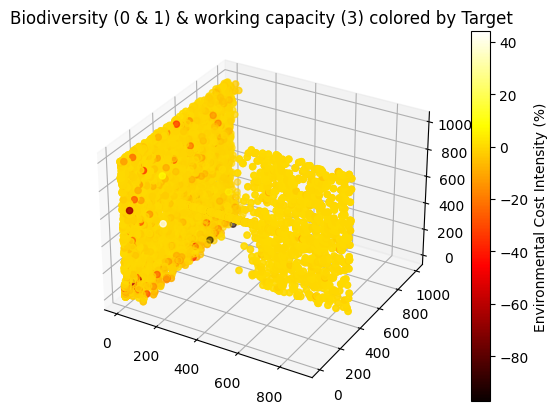

In [ ]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], y, title='Biodiversity (0 & 1) & working capacity (3) colored by Target')

## The Real Data Y 'Prediction' Labels

In [ ]:
predictions = best_model(X.to_numpy())

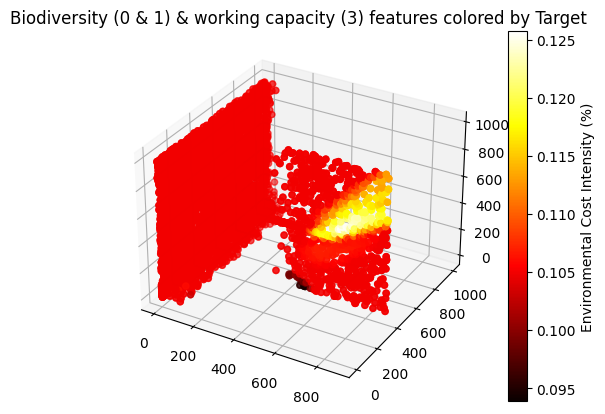

In [ ]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], predictions, title='Biodiversity (0 & 1) & working capacity (3) features colored by Target')

## The Simulated Data Y 'Truth' Labels

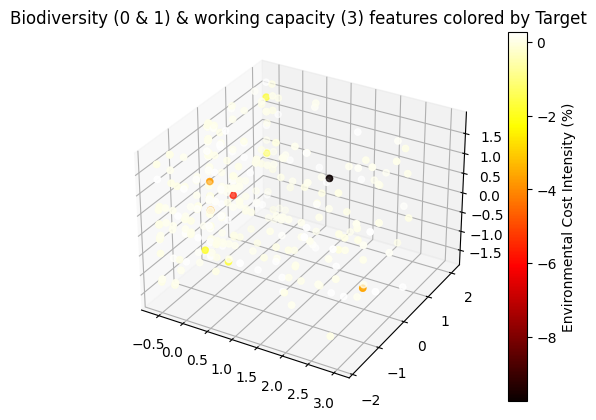

In [184]:
plot_4d(X_test[:,0], X_test[:,1], X_test[:,2], y_test, title='Biodiversity (0 & 1) & working capacity (3) features colored by Target')

## The Simulated Data Y 'Prediction' Labels

In [185]:
simulated_test_predictions = best_model(X_test)

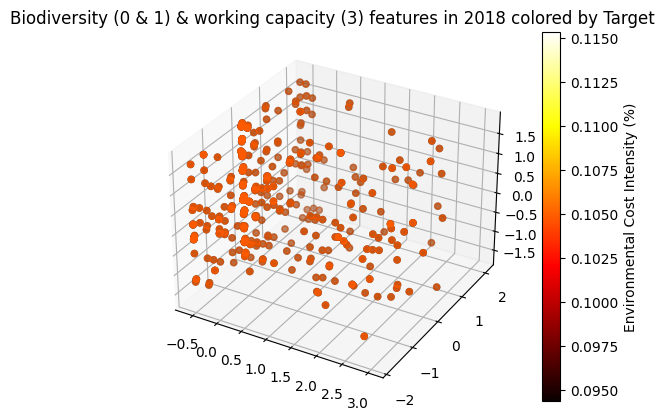

In [186]:
plot_4d(X_test[:,0], X_test[:,1], X_test[:,2], simulated_test_predictions[:,0], title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')

# Conclusion

Using KerasTuner helps find the best hyperparameters before training. It is also possible to pass custom loss and activations and layers, etc. to the model and KerasTuner. However, KerasTuner requires 3 datasets: training, testing, and validation. It has trouble skipping rows in the training set to create a new 'validation' set - so ideally, the data is predefined so that 3 different tf.Datasets are initialized.